# Module 5: Section 3 - Statistical Analysis & Pattern Detection
## Interactive Jupyter Notebook for EDA Training

This notebook accompanies slides 17-27 of the presentation.

---

In [1]:
# Initial Setup - Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, normaltest, levene, ttest_ind, mannwhitneyu, f_oneway
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print('✅ Setup complete!')

✅ Setup complete!


## 1. Testing for Normality
### 📖 Slide 17 - Is Your Data Normally Distributed?

<details>
<summary><b>📊 Click to view slide content</b></summary>

**Testing for Normality**

Statistical Tests:
- **Shapiro-Wilk**: Best for small samples (n < 50)
- **D'Agostino-Pearson**: Good for larger samples
- **Anderson-Darling**: Sensitive to tails

Visual Tools:
- Histograms with normal overlay
- Q-Q plots
- Box plots

</details>

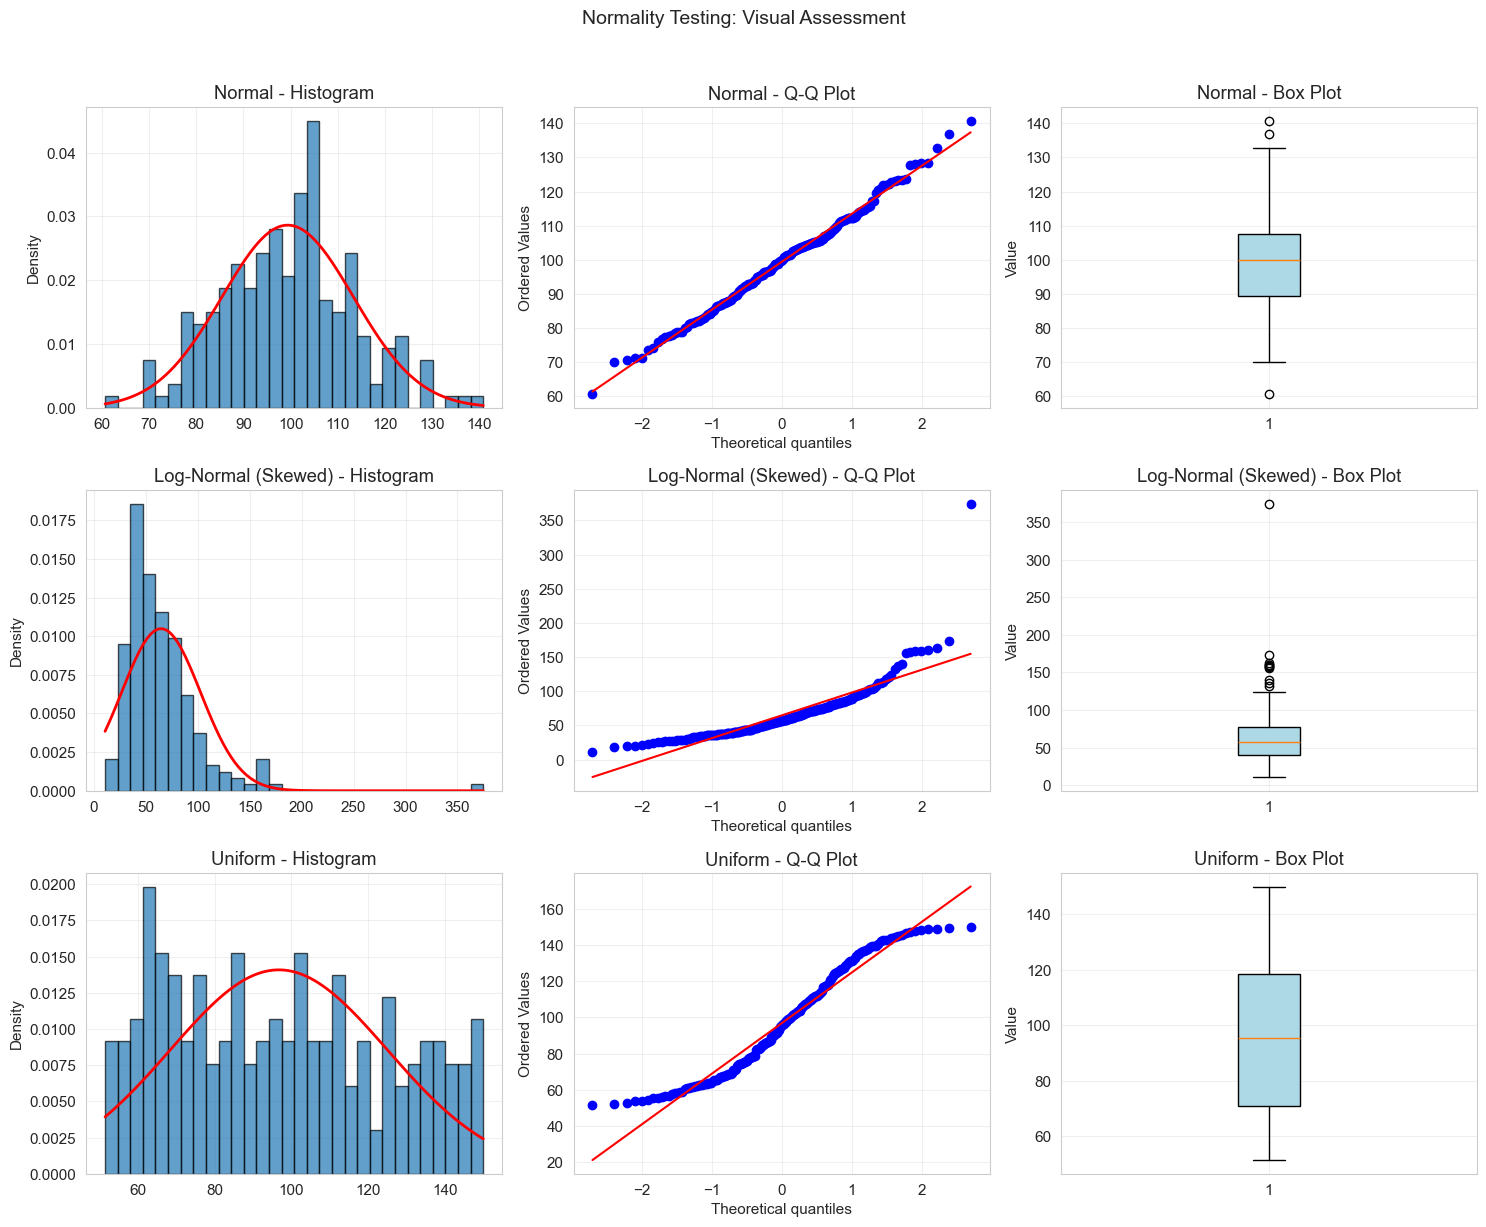


📊 Normality Test Results:
Distribution         Shapiro-Wilk p-value Normal?   
Normal               0.8290               ✓ Yes     
Log-Normal (Skewed)  0.0000               ✗ No      
Uniform              0.0000               ✗ No      


In [2]:
# Generate different distributions for normality testing
np.random.seed(42)
n = 200

# Different distributions
normal_data = np.random.normal(100, 15, n)
skewed_data = np.random.lognormal(4, 0.5, n)
uniform_data = np.random.uniform(50, 150, n)

distributions = {
    'Normal': normal_data,
    'Log-Normal (Skewed)': skewed_data,
    'Uniform': uniform_data
}

# Test normality for each distribution
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for idx, (name, data) in enumerate(distributions.items()):
    # Histogram with normal overlay
    axes[idx, 0].hist(data, bins=30, density=True, alpha=0.7, edgecolor='black')
    x = np.linspace(data.min(), data.max(), 100)
    axes[idx, 0].plot(x, stats.norm.pdf(x, data.mean(), data.std()), 'r-', linewidth=2)
    axes[idx, 0].set_title(f'{name} - Histogram')
    axes[idx, 0].set_ylabel('Density')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Q-Q plot
    stats.probplot(data, dist="norm", plot=axes[idx, 1])
    axes[idx, 1].set_title(f'{name} - Q-Q Plot')
    axes[idx, 1].grid(True, alpha=0.3)
    
    # Box plot
    bp = axes[idx, 2].boxplot(data, vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    axes[idx, 2].set_title(f'{name} - Box Plot')
    axes[idx, 2].set_ylabel('Value')
    axes[idx, 2].grid(True, alpha=0.3)

plt.suptitle('Normality Testing: Visual Assessment', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Statistical tests for normality
print("\n📊 Normality Test Results:")
print("="*60)
print(f"{'Distribution':<20} {'Shapiro-Wilk p-value':<20} {'Normal?':<10}")
print("="*60)

for name, data in distributions.items():
    sw_stat, sw_p = shapiro(data)
    is_normal = "✓ Yes" if sw_p > 0.05 else "✗ No"
    print(f"{name:<20} {sw_p:<20.4f} {is_normal:<10}")

## 2. Comparing Two Groups
### 📖 Slide 18 - Choosing the Right Test

<details>
<summary><b>📊 Click to view slide content</b></summary>

**Comparing Two Groups: Decision Tree**

1. **Assess Normality** (Shapiro-Wilk test)
2. **Evaluate Variance Equality** (Levene's test)
3. **Choose Test**:
   - Normal + Equal variance → Independent t-test
   - Normal + Unequal variance → Welch's t-test
   - Not normal → Mann-Whitney U test

</details>

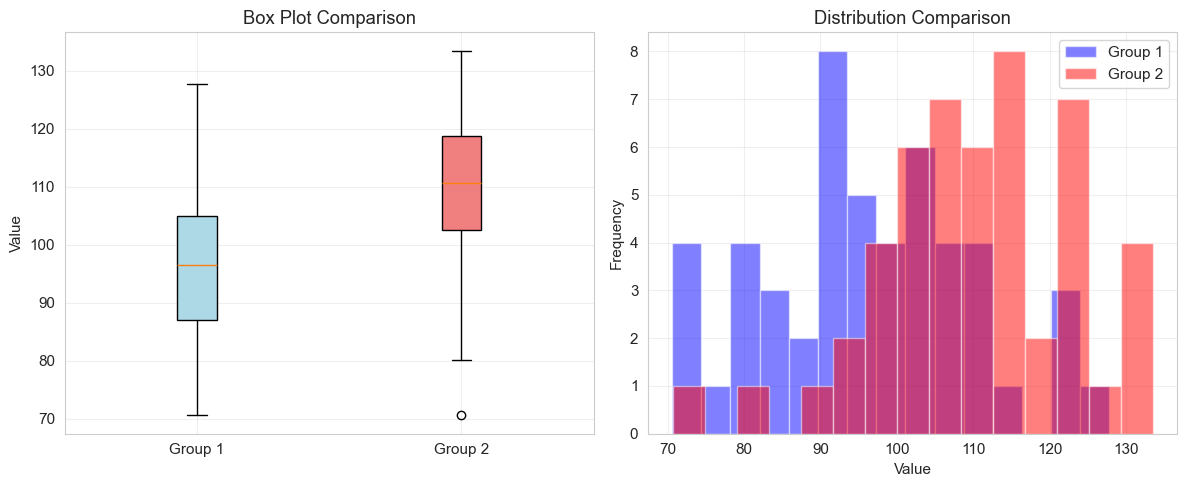


📊 Two-Group Comparison Results:
Selected test: Independent t-test
Test statistic: -5.030
p-value: 0.0000
Effect size (Cohen's d): -1.016
Result: ✓ Significant


In [3]:
# Function to automatically choose and apply the right test
def compare_two_groups(group1, group2, alpha=0.05):
    # Step 1: Test normality
    _, p_norm1 = shapiro(group1)
    _, p_norm2 = shapiro(group2)
    both_normal = (p_norm1 > alpha) and (p_norm2 > alpha)
    
    # Step 2: Test variance equality
    _, p_levene = levene(group1, group2)
    equal_variance = p_levene > alpha
    
    # Step 3: Choose and apply appropriate test
    if both_normal:
        if equal_variance:
            test_name = "Independent t-test"
            stat, p_value = ttest_ind(group1, group2, equal_var=True)
        else:
            test_name = "Welch's t-test"
            stat, p_value = ttest_ind(group1, group2, equal_var=False)
    else:
        test_name = "Mann-Whitney U test"
        stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    
    # Calculate effect size (Cohen's d)
    pooled_std = np.sqrt((np.var(group1) + np.var(group2)) / 2)
    effect_size = (np.mean(group1) - np.mean(group2)) / pooled_std
    
    print(f"\n📊 Two-Group Comparison Results:")
    print(f"Selected test: {test_name}")
    print(f"Test statistic: {stat:.3f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Effect size (Cohen's d): {effect_size:.3f}")
    print(f"Result: {'✓ Significant' if p_value < alpha else '✗ Not significant'}")
    
    return test_name, p_value, effect_size

# Demonstrate with different scenarios
np.random.seed(42)

# Normal with equal variance
group1_normal = np.random.normal(100, 15, 50)
group2_normal = np.random.normal(110, 15, 50)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot
bp = axes[0].boxplot([group1_normal, group2_normal], labels=['Group 1', 'Group 2'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
axes[0].set_title('Box Plot Comparison')
axes[0].set_ylabel('Value')
axes[0].grid(True, alpha=0.3)

# Histogram
axes[1].hist(group1_normal, alpha=0.5, label='Group 1', bins=15, color='blue')
axes[1].hist(group2_normal, alpha=0.5, label='Group 2', bins=15, color='red')
axes[1].set_title('Distribution Comparison')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Run analysis
_ = compare_two_groups(group1_normal, group2_normal)

## 3. Comparing Multiple Groups: ANOVA
### 📖 Slide 19 - ANOVA and Alternatives

<details>
<summary><b>📊 Click to view slide content</b></summary>

**Comparing Multiple Groups**

- **One-way ANOVA**: Tests mean differences assuming normality and equal variances
- **Kruskal-Wallis**: Non-parametric alternative
- **Post-hoc tests**: Tukey HSD to identify specific group differences
- **Effect size**: Eta-squared quantifies variance explained

</details>

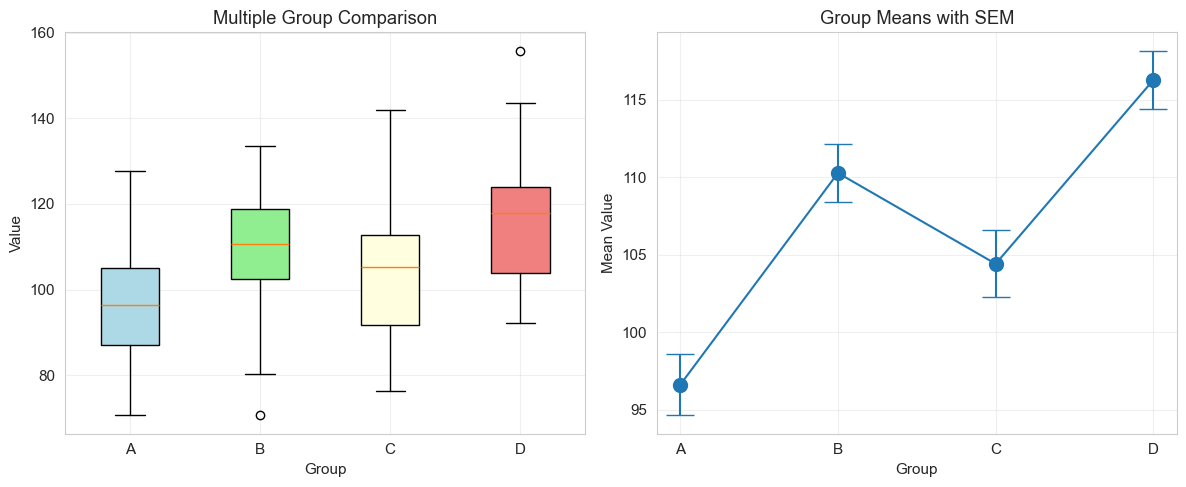


📊 ANOVA Analysis:
F-statistic: 18.024
p-value: 0.0000
Result: ✓ Significant difference between groups


In [4]:
# Generate data for multiple group comparison
np.random.seed(42)

# Create four groups with different means
group_a = np.random.normal(100, 15, 50)
group_b = np.random.normal(110, 15, 50)
group_c = np.random.normal(105, 15, 50)
group_d = np.random.normal(115, 15, 50)

groups = [group_a, group_b, group_c, group_d]
group_labels = ['A', 'B', 'C', 'D']

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot
bp = axes[0].boxplot(groups, labels=group_labels, patch_artist=True)
colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[0].set_title('Multiple Group Comparison')
axes[0].set_xlabel('Group')
axes[0].set_ylabel('Value')
axes[0].grid(True, alpha=0.3)

# Mean with error bars
means = [np.mean(g) for g in groups]
sems = [stats.sem(g) for g in groups]
axes[1].errorbar(range(len(groups)), means, yerr=sems, fmt='o-', capsize=10, markersize=10)
axes[1].set_xticks(range(len(groups)))
axes[1].set_xticklabels(group_labels)
axes[1].set_title('Group Means with SEM')
axes[1].set_xlabel('Group')
axes[1].set_ylabel('Mean Value')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical tests
f_stat, p_value_anova = f_oneway(*groups)

print("\n📊 ANOVA Analysis:")
print(f"F-statistic: {f_stat:.3f}")
print(f"p-value: {p_value_anova:.4f}")
print(f"Result: {'✓ Significant difference between groups' if p_value_anova < 0.05 else '✗ No significant difference'}")

## 4. Confidence Intervals
### 📖 Slide 21 - Quantifying Uncertainty

<details>
<summary><b>📊 Click to view slide content</b></summary>

**Confidence Intervals: Quantifying Uncertainty**

- **Purpose**: Provide range of plausible values for estimates
- **Interpretation**: 95% CI means if sampling repeated, 95% of intervals would contain true parameter
- **Methods**: Normal approximation, t-distribution, bootstrap

</details>

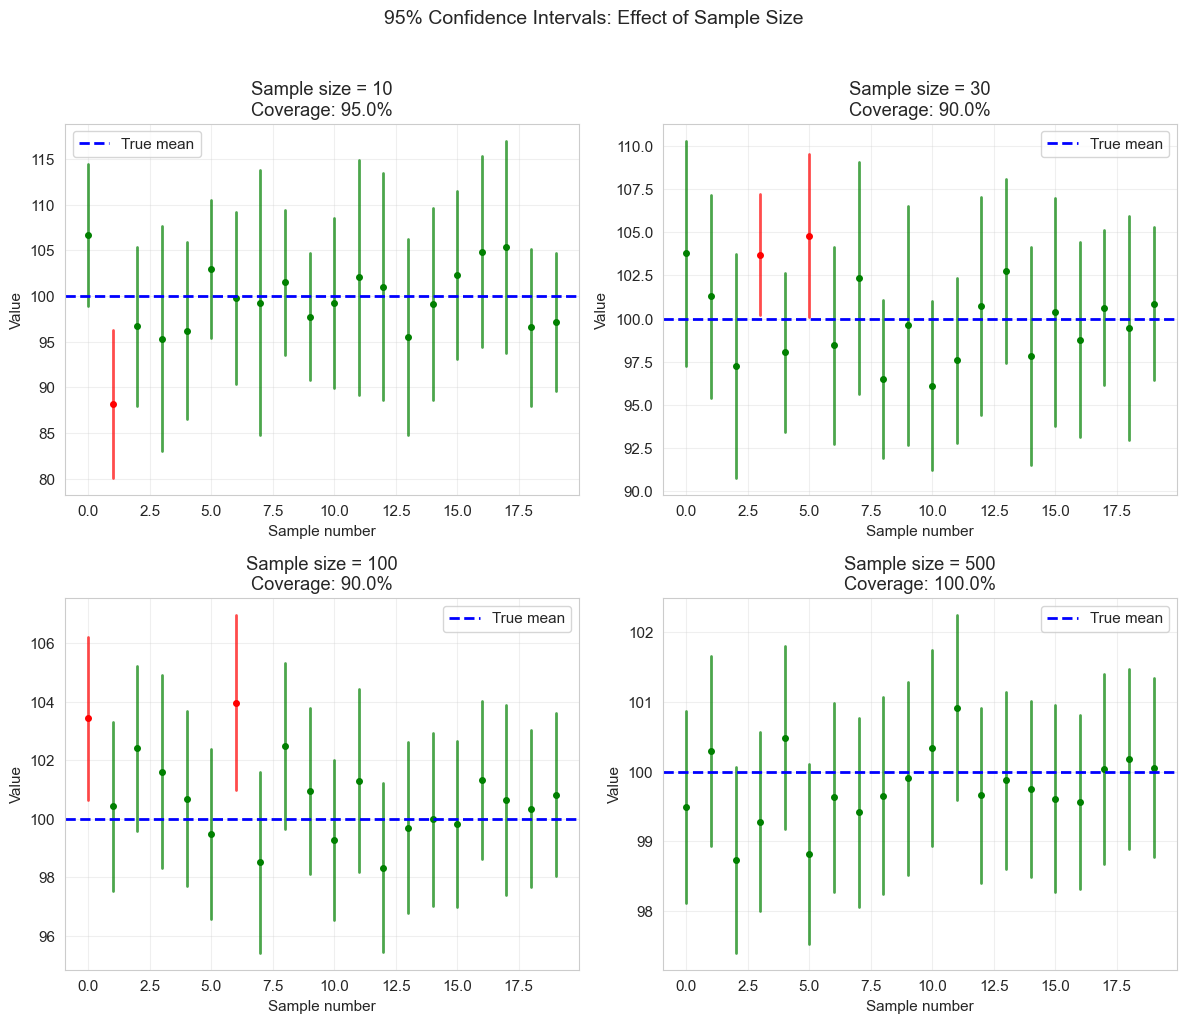


📊 Confidence Interval Interpretation:
Green intervals contain the true mean
Red intervals miss the true mean
Larger samples → narrower intervals (more precision)


In [5]:
# Demonstrate confidence intervals
np.random.seed(42)

# True population parameters
true_mean = 100
true_std = 15

# Different sample sizes
sample_sizes = [10, 30, 100, 500]
n_simulations = 20

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, n in enumerate(sample_sizes):
    ci_contains_true = []
    
    for sim in range(n_simulations):
        sample = np.random.normal(true_mean, true_std, n)
        sample_mean = np.mean(sample)
        sample_sem = stats.sem(sample)
        
        # Calculate 95% CI using t-distribution
        ci = stats.t.interval(0.95, n-1, sample_mean, sample_sem)
        
        # Check if CI contains true mean
        contains = ci[0] <= true_mean <= ci[1]
        ci_contains_true.append(contains)
        
        # Plot CI
        color = 'green' if contains else 'red'
        axes[idx].plot([sim, sim], ci, color=color, alpha=0.7, linewidth=2)
        axes[idx].plot(sim, sample_mean, 'o', color=color, markersize=4)
    
    # Add true mean line
    axes[idx].axhline(y=true_mean, color='blue', linestyle='--', linewidth=2, label='True mean')
    
    # Calculate coverage
    coverage = np.mean(ci_contains_true) * 100
    
    axes[idx].set_title(f'Sample size = {n}\nCoverage: {coverage:.1f}%')
    axes[idx].set_xlabel('Sample number')
    axes[idx].set_ylabel('Value')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('95% Confidence Intervals: Effect of Sample Size', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n📊 Confidence Interval Interpretation:")
print("Green intervals contain the true mean")
print("Red intervals miss the true mean")
print("Larger samples → narrower intervals (more precision)")

## 5. Effect Size
### 📖 Slide 22 - Beyond P-Values

<details>
<summary><b>📊 Click to view slide content</b></summary>

**Effect Size Matters: Beyond P-Values**

Common Measures:
- **Cohen's d**: Standardized mean difference
- **R-squared**: Proportion of variance explained

Guidelines:
- Small: d = 0.2
- Medium: d = 0.5
- Large: d = 0.8

</details>

In [6]:
# Demonstrate the importance of effect size
np.random.seed(42)

# Create scenarios with different effect sizes but varying sample sizes
scenarios = [
    {'n': 20, 'effect': 0.8, 'label': 'Small n, Large effect'},
    {'n': 200, 'effect': 0.3, 'label': 'Large n, Small effect'},
    {'n': 1000, 'effect': 0.1, 'label': 'Very large n, Tiny effect'}
]

results_summary = []

for scenario in scenarios:
    n = scenario['n']
    true_effect = scenario['effect']
    
    # Generate data with specified effect size
    group1 = np.random.normal(0, 1, n)
    group2 = np.random.normal(true_effect, 1, n)
    
    # Statistical test
    t_stat, p_value = ttest_ind(group1, group2)
    
    # Calculate actual effect size
    pooled_std = np.sqrt((np.var(group1) + np.var(group2)) / 2)
    actual_d = (np.mean(group2) - np.mean(group1)) / pooled_std
    
    results_summary.append({
        'Scenario': scenario['label'],
        'Sample Size': n,
        'P-value': p_value,
        'Significant': p_value < 0.05,
        "Cohen's d": actual_d
    })

# Summary table
results_df = pd.DataFrame(results_summary)
print("\n📊 Statistical Significance vs Practical Significance:")
print(results_df.to_string(index=False))
print("\n💡 Key Insight: Large samples can make tiny effects statistically significant!")


📊 Statistical Significance vs Practical Significance:
                 Scenario  Sample Size  P-value  Significant  Cohen's d
    Small n, Large effect           20 0.026194         True   0.750638
    Large n, Small effect          200 0.001186         True   0.327392
Very large n, Tiny effect         1000 0.091416        False   0.075563

💡 Key Insight: Large samples can make tiny effects statistically significant!


## 6. Outlier Detection
### 📖 Slide 23 - Finding Anomalies

<details>
<summary><b>📊 Click to view slide content</b></summary>

**Outlier Detection Methods**

Statistical Methods:
- **IQR Method**: Points outside 1.5×IQR from quartiles
- **Z-score**: Values with |z| > 3

</details>

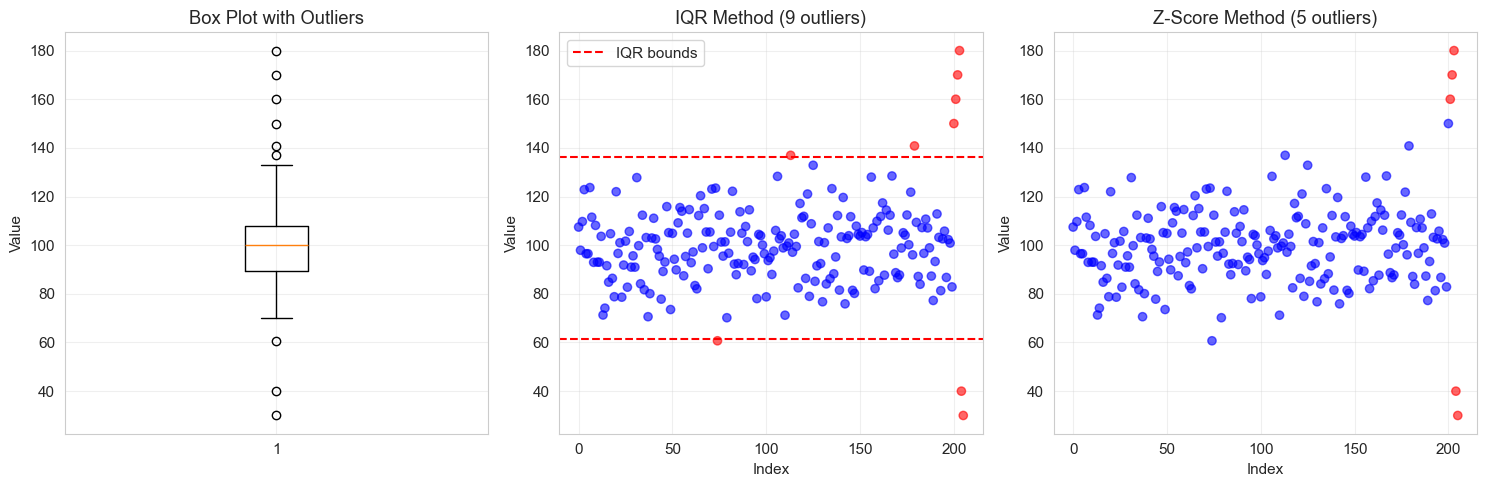


📊 Outlier Detection Summary:
Total data points: 206
IQR Method: 9 outliers detected
Z-Score Method: 5 outliers detected


In [7]:
# Demonstrate outlier detection methods
np.random.seed(42)

# Generate data with outliers
n_samples = 200
normal_data = np.random.normal(100, 15, n_samples)

# Add outliers
outliers = np.array([150, 160, 170, 180, 40, 30])
data_with_outliers = np.concatenate([normal_data, outliers])

# IQR method
Q1 = np.percentile(data_with_outliers, 25)
Q3 = np.percentile(data_with_outliers, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_iqr = (data_with_outliers < lower_bound) | (data_with_outliers > upper_bound)

# Z-score method
z_scores = np.abs(stats.zscore(data_with_outliers))
outliers_zscore = z_scores > 3

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Box plot
axes[0].boxplot(data_with_outliers)
axes[0].set_title('Box Plot with Outliers')
axes[0].set_ylabel('Value')
axes[0].grid(True, alpha=0.3)

# IQR method
axes[1].scatter(range(len(data_with_outliers)), data_with_outliers,
               c=['red' if outlier else 'blue' for outlier in outliers_iqr],
               alpha=0.6)
axes[1].axhline(y=lower_bound, color='red', linestyle='--', label='IQR bounds')
axes[1].axhline(y=upper_bound, color='red', linestyle='--')
axes[1].set_title(f'IQR Method ({np.sum(outliers_iqr)} outliers)')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Value')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Z-score method
axes[2].scatter(range(len(data_with_outliers)), data_with_outliers,
               c=['red' if outlier else 'blue' for outlier in outliers_zscore],
               alpha=0.6)
axes[2].set_title(f'Z-Score Method ({np.sum(outliers_zscore)} outliers)')
axes[2].set_xlabel('Index')
axes[2].set_ylabel('Value')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Outlier Detection Summary:")
print(f"Total data points: {len(data_with_outliers)}")
print(f"IQR Method: {np.sum(outliers_iqr)} outliers detected")
print(f"Z-Score Method: {np.sum(outliers_zscore)} outliers detected")

## 7. Pattern Detection with PCA
### 📖 Slide 24 - Discovering Hidden Structures

<details>
<summary><b>📊 Click to view slide content</b></summary>

**Pattern Detection: PCA**

Workflow:
1. **Standardize Data**: Ensure comparability
2. **Scree Plot**: Evaluate variance explained
3. **PCA Projections**: Visualize in PC space
4. **Feature Importance**: Analyze loadings

</details>

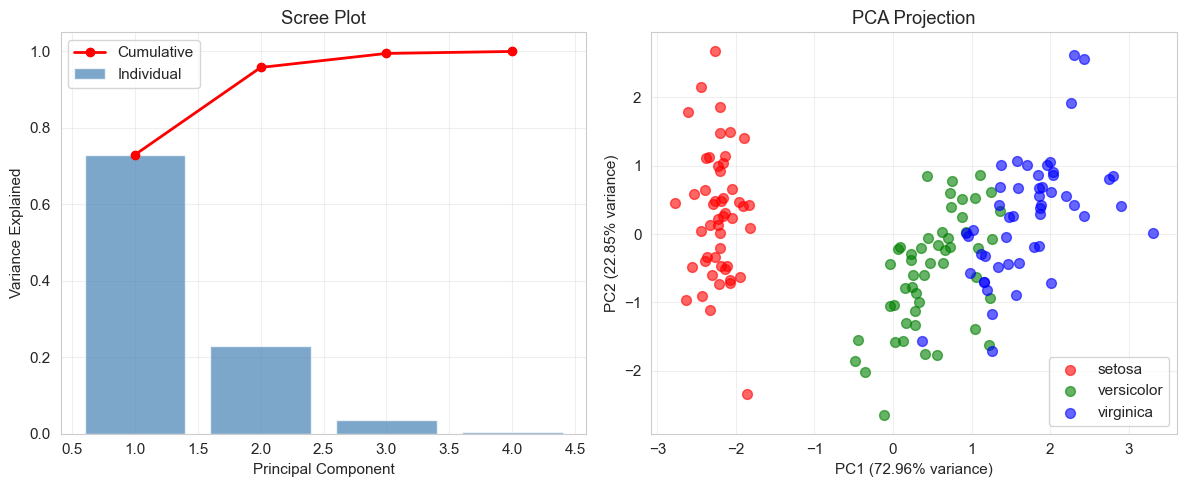


📊 PCA Analysis Results:
Total variance explained by first 2 PCs: 95.81%
Clear separation between species in PC space


In [8]:
# Demonstrate PCA for pattern detection
from sklearn.datasets import load_iris

# Load iris dataset
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scree plot
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

axes[0].bar(range(1, len(explained_variance_ratio) + 1), 
           explained_variance_ratio, alpha=0.7, color='steelblue', label='Individual')
axes[0].plot(range(1, len(cumulative_variance) + 1), 
            cumulative_variance, 'ro-', linewidth=2, label='Cumulative')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained')
axes[0].set_title('Scree Plot')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# PCA projection
colors = ['red', 'green', 'blue']
for i, color in enumerate(colors):
    mask = y == i
    axes[1].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   c=color, label=iris.target_names[i], alpha=0.6, s=50)
axes[1].set_xlabel(f'PC1 ({explained_variance_ratio[0]:.2%} variance)')
axes[1].set_ylabel(f'PC2 ({explained_variance_ratio[1]:.2%} variance)')
axes[1].set_title('PCA Projection')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 PCA Analysis Results:")
print(f"Total variance explained by first 2 PCs: {cumulative_variance[1]:.2%}")
print(f"Clear separation between species in PC space")

## Practice Exercise

### 🎯 Complete Statistical Analysis
Apply what you've learned to perform a complete statistical analysis.

In [9]:
# Practice Exercise: Statistical Analysis Workflow
print("🎯 PRACTICE EXERCISE: Complete Statistical Analysis")
print("="*50)
print("Tasks:")
print("1. Generate or load a dataset with at least 3 groups")
print("2. Test assumptions (normality, variance equality)")
print("3. Choose and apply appropriate statistical test")
print("4. Calculate effect sizes")
print("5. Create visualizations")
print("\nYour code here:")

# START YOUR CODE HERE
# Example starter:
# group1 = np.random.normal(100, 15, 50)
# group2 = np.random.normal(105, 15, 50)
# group3 = np.random.normal(110, 15, 50)
# ...

🎯 PRACTICE EXERCISE: Complete Statistical Analysis
Tasks:
1. Generate or load a dataset with at least 3 groups
2. Test assumptions (normality, variance equality)
3. Choose and apply appropriate statistical test
4. Calculate effect sizes
5. Create visualizations

Your code here:


## Summary

### 📚 Key Takeaways from Section 3:

1. **Statistical Testing Framework**
   - Always check assumptions before applying tests
   - Choose appropriate tests based on data characteristics

2. **Normality Testing**
   - Use both visual and statistical methods
   - Consider transformations when needed

3. **Group Comparisons**
   - Two groups: t-test, Welch's, or Mann-Whitney U
   - Multiple groups: ANOVA or Kruskal-Wallis

4. **Beyond P-values**
   - Effect size matters for practical significance
   - Confidence intervals quantify uncertainty

5. **Pattern Detection**
   - Outlier detection with multiple methods
   - PCA for dimensionality reduction

### 💡 Remember:
- Statistical significance ≠ Practical significance
- Always report both p-values AND effect sizes
- Combine multiple methods for robust conclusions

---
**End of Section 3: Statistical Analysis & Pattern Detection**